# Импорт библиотек

In [ ]:
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial import distance
from scipy.optimize import minimize
import numpy as np
import sklearn
from tqdm.notebook import tqdm

# MDS

## Немного теории

Рассмотрим еще один [метод снижения размерности](https://en.wikipedia.org/wiki/Multidimensional_scaling) под названием MDS. Существует достаточно большое количество различных эвристик и модификаций этого метода. Мы будем рассматривать так называемый метрический MDS.

Пусть у насть есть матрица исходных данных $Z \in \mathbb{R}^{n\times p}$. Мы хотим понизить размерность до, например, двух, то есть получить матрицу $X \in \mathbb{R}^{n\times 2}$.

Для этого вычислим матрицу исходных расстояний $D = (d_{ij}) \in \mathbb{R}^{n \times n}$, где $d_{ii} = 0$, $d_{ij} = d_{ji} \geq 0$. Вообще говоря в качестве расстояний здесь можно использовать не только метрики типа евклидова расстояния и тп, но мы будем использовать именно евклидово расстояние.

Для нового пространства признаков для любых $i, j$ определим евклидово расстояние:
$$
\hat{d}_{ij} = \|x_i - x_j\| = \sqrt{(x_i - x_j)^\top (x_i - x_j)}.
$$

В метрическом MDS классическая функция стресса Крускала (Kruskal’s stress) определяется как:

$$
\sigma(X) = \sqrt{ \frac{ \sum_{i<j} w_{ij} (d_{ij}(X) - \delta_{ij})^2 }{ \sum_{i<j} w_{ij} \delta_{ij}^2 } }
$$

где:
- $X \in \mathbb{R}^{n \times p}$ — искомые координаты точек в $p$-мерном пространстве,
- $d_{ij}(X) = \|x_i - x_j\|$ — евклидово расстояние между точками $i$ и $j$,
- $\delta_{ij}$ — заданная диссимилярность (заданное "расстояние") ,
- $w_{ij} \geq 0$ — вес (обычно $w_{ij}=1$ для всех пар в базовой версии).

Хотя классическая функция стресса Крускала включает нормировку и корень, в оптимизационных целях часто минимизируют более простую версию — так называемый raw stress, в котором отсутствуют корень и нормирующий знаменатель. Именно его мы будем использовать (не вводя новых обозначений).

$$
\sigma(X) = \sum_{i < j} \bigl( \hat{d}_{ij} - d_{ij} \bigr)^2.
$$

По сути это сумма квадратов отклонений между целевыми расстояниями $d_{ij}$ и текущими $\hat{d}_{ij}$.

Для удобства дифференцирования перепишем сумму по всем упорядоченным парам $i \ne j$, разделив на 2 (так как каждая неупорядоченная пара учитывается дважды):

$$
\sigma(X) = \frac{1}{2} \sum_{i=1}^n \sum_{\substack{j=1 \\ j \ne i}}^n \bigl( \hat{d}_{ij} - d_{ij} \bigr)^2 = \frac{1}{2} \sum_{i=1}^n \sum_{\substack{j=1 \\ j \ne i}}^n \bigl( \|x_i - x_j\| - d_{ij} \bigr)^2.
$$

Рассмотрим одно слагаемое в сумме:  
$$
f_{ij}(X) = \bigl( \|x_i - x_j\| - d_{ij} \bigr)^2.
$$

Найдём градиент $f_{ij}$ по $x_i$, получим

$$
\nabla_{x_i} f_{ij} = 2\bigl( \|x_i - x_j\| - d_{ij} \bigr)\frac{\partial}{\partial x_i} \|x_i - x_j\|.
$$

С учетом того, что
$$
\frac{\partial}{\partial x_i} \|x_i - x_j\| = \frac{\partial}{\partial x_i} \sqrt{(x_i - x_j)^\top (x_i - x_j)} = \frac{x_i - x_j}{\|x_i - x_j\|},
$$

получим

$$
\nabla_{x_i} f_{ij} = 2\bigl( \|x_i - x_j\| - d_{ij} \bigr)\frac{(x_i - x_j)}{\|x_i - x_j\|} =
$$

$$
= 2 \left( 1 - \frac{d_{ij}}{\|x_i - x_j\|} \right)(x_i - x_j).
$$

⚠️ **Важно**: это выражение определено только если $\|x_i - x_j\| > 0$, то есть $x_i \ne x_j$.

Осталось просуммировать. Учтём, что сумма идёт по всем $j \ne i$. Каждое слагаемое $f_{ij}$ вносит вклад в градиент по $x_i$.

Следовательно:

$$
\nabla_{x_i} \sigma = \frac{1}{2} \sum_{j \ne i} \nabla_{x_i} f_{ij}
= \frac{1}{2} \sum_{j \ne i} 2 \left( 1 - \frac{d_{ij}}{\|x_i - x_j\|} \right) (x_i - x_j).
$$

Двойки сокращаются:

$$
\nabla_{x_i} \sigma = \sum_{j \ne i} \left( 1 - \frac{d_{ij}}{\|x_i - x_j\|} \right) (x_i - x_j)
$$

Все бы хорошо, но проблему со знаменателем мы пока не решили. Исправим это при помощи так называемой **$\varepsilon$-регуляризации**:

Чтобы избежать деления на ноль, заменим евклидово расстояние на сглаженное приближение:

$$
\hat{d}_{ij}^\varepsilon = \sqrt{ \|x_i - x_j\|^2 + \varepsilon^2 }, \quad \varepsilon > 0.
$$

Тогда минимизируемое выражение примет вид

$$
\boxed{
\sigma^\varepsilon(X) = \frac{1}{2} \sum_{i=1}^n \sum_{\substack{j=1 \\ j \ne i}}^n \bigl( \sqrt{\|x_i - x_j\|^2 + \varepsilon^2} - d_{ij} \bigr)^2
},
$$

а градиент соответственно:

$$
\boxed{
\nabla_{x_i} \sigma^\varepsilon = \sum_{j \ne i} \left( 1 - \frac{d_{ij}}{\sqrt{\|x_i - x_j\|^2 + \varepsilon^2}} \right) (x_i - x_j)
}.
$$

В результате шаг градиентного спуска для одной точки $x_i$

$$
x_i^{(t+1)} = x_i^{(t)} - \eta \cdot (\nabla_{x_i} \sigma^\varepsilon)^{(t)}.
$$

**Примечание**: все точки необходимо обновлять одновременно.

## Реализация вручную

In [ ]:
link = 'https://storage.yandexcloud.net/lms-itmo-ru-files-27a87tyf/machine_learning/task2/task2.1/data/94_16.csv'
data = pd.read_csv(link, header = None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,10.382991,-14.438544,-23.950798,-17.809813,2.480495,-15.743114,-9.112421,-27.390035,-11.955001,18.069910
1,18.987842,-13.071734,15.619164,-11.288528,-11.624820,14.845464,-4.924935,21.207876,-23.703025,4.440474
2,7.426000,-9.236580,-21.139348,6.732592,0.447684,-20.687020,-18.545136,7.758288,18.620790,-3.006755
3,10.718844,-10.240587,-20.604991,4.828083,-0.073568,-23.747055,-17.260869,7.074364,16.996747,-6.796469
4,10.662165,3.871777,12.384108,-1.921321,-1.990254,-5.469310,2.801321,-19.978717,23.414766,-2.654889


In [ ]:
Z = data.to_numpy()

### Задача 1

In [ ]:
# Матрица расстояний исходных объектов

def get_distance_matrix(Z):
  """
    Вычисляет матрицу попарных евклидовых расстояний между точками в многомерном пространстве.

    Parameters
    ----------
    Z : array-like of shape (n_samples, n_features)
        Исходные данные в высокоразмерном пространстве.

    Returns
    -------
    dist_matrix : ndarray of shape (n_samples, n_samples)
        Симметричная матрица расстояний, где элемент [i, j] - это евклидово расстояние
        между i-й и j-й точками в массиве Z. Диагональные элементы равны 0.
  """
  pass

dist_matrix = get_distance_matrix(Z)

assert np.all(np.isclose(dist_matrix[0,:10],np.array([ 0., 74.30956345, 58.12140831, 57.64306698, 62.53764151, 6.38347952, 56.4617336 ,  7.83587303, 53.82804388,  6.54015292])))



In [ ]:
# Инициализируем новые координаты

def initialize_X(n_samples, n_components, random_state=42):
  """
    Инициализирует начальные координаты точек в низкоразмерном пространстве.
    Использует зерно NumPy + равномерное распределение NumPy

    Parameters
    ----------
    n_samples : int
        Количество точек (объектов).
    n_components : int
        Размерность целевого пространства (например, 2 для визуализации).
    random_state : int, RandomState instance or None, default=None
        Зерно для генератора случайных чисел, чтобы сделать результат воспроизводимым.

    Returns
    -------
    X_init : ndarray of shape (n_samples, n_components)
        Массив, содержащий случайно инициализированные координаты всех точек
        в целевом низкоразмерном пространстве.
  """
  pass

X = initialize_X(len(Z), n_components=2, random_state=42)

assert np.all(np.isclose(X[:4], np.array([[0.37454012, 0.95071431], [0.73199394, 0.59865848], [0.15601864, 0.15599452], [0.05808361, 0.86617615]])))

### Задача 2

In [ ]:
def compute_stress(dist_matrix, X, epsilon=1e-8):
    """
    Вычисляет значение стресс функции для текущей конфигурации точек.

    Parameters
    ----------
    dist_matrix : ndarray of shape (n_samples, n_samples)
        Матрица исходных попарных расстояний.
    X : ndarray of shape (n_samples, n_components)
        Текущая конфигурация точек в низкоразмерном пространстве.
    epsilon : float, default=1e-8
        Параметр регуляризации, предотвращающий деление на ноль.

    Returns
    -------
    stress : float
        Значение функции стресса.
    """
    pass

start_stress =  compute_stress(dist_matrix, X, epsilon=1e-8)

assert np.isclose(start_stress, 5652832.39828312)

In [ ]:
def compute_gradient(dist_matrix, X, epsilon=1e-8):
    """
    Вычисляет градиент функции стресса по координатам всех точек.

    Parameters
    ----------
    dist_matrix : ndarray of shape (n_samples, n_samples)
        Матрица исходных попарных расстояний.
    X : ndarray of shape (n_samples, n_components)
        Текущая конфигурация точек в низкоразмерном пространстве.
    epsilon : float, default=1e-8
        Параметр регуляризации, предотвращающий деление на ноль.

    Returns
    -------
    gradient : ndarray of shape (n_samples, n_components)
        Градиент функции стресса по отношению к координатам каждой точки.
        Каждая строка этого массива - это вектор градиента для одной точки.
    """
    pass

gradient = compute_gradient(dist_matrix, X, epsilon=1e-8)

assert np.all(np.isclose(gradient[:5], np.array([[  312.75577955, -2102.47253488], [-1297.85452143,  -570.5142918 ], [ 1486.99111953,  1320.44919964], [ 1426.92855035, -1364.58914418], [ -741.82909767, -1182.4748548 ]])))

### Собираем все вместе

In [ ]:
def mds_fit(dist_matrix, X, max_iter=500, tol=1e-4, learning_rate=0.01, epsilon=1e-8):
    """
    Выполняет полную оптимизацию метрического MDS с использованием градиентного спуска
    и ε-регуляризации.

    Алгоритм минимизирует функцию стресса до достижения одного из критериев остановки:
    1) Достигнуто максимальное количество итераций (max_iter).
    2) Изменение значения стресса стало меньше заданной допустимой погрешности (tol).

    Parameters
    ----------
    dist_matrix : ndarray of shape (n_samples, n_samples)
        Матрица исходных попарных расстояний (или диссимилярностей).
    X : ndarray of shape (n_samples, n_components), optional
        Начальная конфигурация точек в низкоразмерном пространстве.
        Если None, используется случайная инициализация.
    max_iter : int, default=300
        Максимальное количество итераций.
    tol : float, default=1e-4
        Минимальное изменение значения функции стресса для продолжения итераций.
        Алгоритм останавливается, когда |stress_{t} - stress_{t-1}| < tol.
    learning_rate : float, default=1.0
        Темп обучения (коэффициент шага градиентного спуска).
    epsilon : float, default=1e-8
        Параметр регуляризации, предотвращающий деление на ноль.

    Returns
    -------
    X_final : ndarray of shape (n_samples, n_components)
        Окончательная конфигурация точек после выполнения всех итераций.
    stress_history : list of float
        Список, содержащий значение функции стресса на каждой итерации.
    """

    # Переменные для отслеживания истории и критериев остановки
    stress_history = []
    old_stress = None

    for it in tqdm(range(max_iter)):
        # Сохраняем текущее значение стресса
        current_stress = compute_stress(dist_matrix, X, epsilon)
        stress_history.append(current_stress)

        # Проверяем критерий остановки по изменению стресса
        if old_stress is not None:
            if abs(old_stress - current_stress) < tol:
                break

        # Обновляем старое значение стресса
        old_stress = current_stress

        # Вычисляем градиент и выполняем шаг градиентного спуска
        grad = compute_gradient(dist_matrix, X, epsilon)
        X = X - learning_rate * grad

    return X, stress_history

X_new, stress_history = mds_fit(dist_matrix, X)

Визуализируем результат

In [ ]:
# Убывание функции стресса

plt.plot(stress_history)

In [ ]:
# Результат снижения размерности

plt.scatter(x=X_new[:,0], y=X_new[:,1])

## Замечание

**Дисклеймер:**

Мы использовали именно такую функцию стресса и алгоритм градиентного спуска для ее минимизации в образовательных целях. В библиотечной реализации используется так называемый алгоритм SMACOF. Более подробно про функцию стресса и алгоритм минимизации можно посмотреть в документации самой библиотеки или [вот тут](https://en.wikipedia.org/wiki/Stress_majorization).

## То же самое, но библиотекой

In [ ]:
mds = MDS(n_components=2, normalized_stress='auto')
data_mds = mds.fit_transform(data)
data_mds[:5]

array([[ 14.31942968, -36.99455278],
       [ 41.99912482,  24.41823072],
       [-30.06805435, -16.44709179],
       [-28.9274378 , -17.64291052],
       [-25.92788539,  27.44010869]])

In [ ]:
plt.scatter(x=data_mds[:,0], y=data_mds[:,1])

## По шагам

In [ ]:
# @title Код для сохранения истории

# Модифицированный код из библиотеки, чтобы можно было проследить историю



def _smacof_single(
    dissimilarities,
    metric=True,
    n_components=2,
    init=None,
    max_iter=300,
    verbose=0,
    eps=1e-3,
    random_state=None,
    normalized_stress=False,
):

    dissimilarities = check_symmetric(dissimilarities, raise_exception=True)

    n_samples = dissimilarities.shape[0]
    random_state = check_random_state(random_state)

    sim_flat = ((1 - np.tri(n_samples)) * dissimilarities).ravel()
    sim_flat_w = sim_flat[sim_flat != 0]
    if init is None:
        # Randomly choose initial configuration
        X = random_state.uniform(size=n_samples * n_components)
        X = X.reshape((n_samples, n_components))
    else:
        # overrides the parameter p
        n_components = init.shape[1]
        if n_samples != init.shape[0]:
            raise ValueError(
                "init matrix should be of shape (%d, %d)" % (n_samples, n_components)
            )
        X = init

    old_stress = None
    ir = IsotonicRegression()
    history = []
    for it in range(max_iter):
        history.append(X)
        # Compute distance and monotonic regression
        dis = euclidean_distances(X)

        if metric:
            disparities = dissimilarities
        else:
            dis_flat = dis.ravel()
            # dissimilarities with 0 are considered as missing values
            dis_flat_w = dis_flat[sim_flat != 0]

            # Compute the disparities using a monotonic regression
            disparities_flat = ir.fit_transform(sim_flat_w, dis_flat_w)
            disparities = dis_flat.copy()
            disparities[sim_flat != 0] = disparities_flat
            disparities = disparities.reshape((n_samples, n_samples))
            disparities *= np.sqrt(
                (n_samples * (n_samples - 1) / 2) / (disparities**2).sum()
            )

        # Compute stress
        stress = ((dis.ravel() - disparities.ravel()) ** 2).sum() / 2
        if normalized_stress:
            stress = np.sqrt(stress / ((disparities.ravel() ** 2).sum() / 2))
        # Update X using the Guttman transform
        dis[dis == 0] = 1e-5
        ratio = disparities / dis
        B = -ratio
        B[np.arange(len(B)), np.arange(len(B))] += ratio.sum(axis=1)
        X = 1.0 / n_samples * np.dot(B, X)

        dis = np.sqrt((X**2).sum(axis=1)).sum()
        if verbose >= 2:
            print("it: %d, stress %s" % (it, stress))
        if old_stress is not None:
            if (old_stress - stress / dis) < eps:
                if verbose:
                    print("breaking at iteration %d with stress %s" % (it, stress))
                break
        old_stress = stress / dis

    return X, stress, it + 1, history

def smacof(
    dissimilarities,
    *,
    metric=True,
    n_components=2,
    init=None,
    n_init=8,
    n_jobs=None,
    max_iter=300,
    verbose=0,
    eps=1e-3,
    random_state=None,
    return_n_iter=False,
    normalized_stress="auto",
):

    dissimilarities = check_array(dissimilarities)
    random_state = check_random_state(random_state)

    if normalized_stress == "auto":
        normalized_stress = not metric

    if normalized_stress and metric:
        raise ValueError(
            "Normalized stress is not supported for metric MDS. Either set"
            " `normalized_stress=False` or use `metric=False`."
        )
    if hasattr(init, "__array__"):
        init = np.asarray(init).copy()
        if not n_init == 1:
            warnings.warn(
                "Explicit initial positions passed: "
                "performing only one init of the MDS instead of %d" % n_init
            )
            n_init = 1

    best_pos, best_stress = None, None


    if effective_n_jobs(n_jobs) == 1:
        for it in range(n_init):
            pos, stress, n_iter_, history = _smacof_single(
                dissimilarities,
                metric=metric,
                n_components=n_components,
                init=init,
                max_iter=max_iter,
                verbose=verbose,
                eps=eps,
                random_state=random_state,
                normalized_stress=normalized_stress,
            )
            if best_stress is None or stress < best_stress:
                best_stress = stress
                best_pos = pos.copy()
                best_iter = n_iter_
    else:
        seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)
        results = Parallel(n_jobs=n_jobs, verbose=max(verbose - 1, 0))(
            delayed(_smacof_single)(
                dissimilarities,
                metric=metric,
                n_components=n_components,
                init=init,
                max_iter=max_iter,
                verbose=verbose,
                eps=eps,
                random_state=seed,
                normalized_stress=normalized_stress,
            )
            for seed in seeds
        )
        positions, stress, n_iters = zip(*results)
        best = np.argmin(stress)
        best_stress = stress[best]
        best_pos = positions[best]
        best_iter = n_iters[best]

    if return_n_iter:
        return best_pos, best_stress, best_iter, history
    else:
        return best_pos, best_stress

from sklearn import *
import numpy as np
from joblib import effective_n_jobs

from sklearn.base import BaseEstimator, _fit_context
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import euclidean_distances
from sklearn.utils import check_array, check_random_state, check_symmetric
from sklearn.utils._param_validation import Interval, StrOptions, validate_params
from sklearn.utils.parallel import Parallel, delayed
#from sklearn.manifold._mds import _smacof_single


class MDS_modified(MDS):
  def fit_transform(self, X, y=None, init=None):
        """
        Fit the data from `X`, and returns the embedded coordinates.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) or \
                (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.

        y : Ignored
            Not used, present for API consistency by convention.

        init : ndarray of shape (n_samples, n_components), default=None
            Starting configuration of the embedding to initialize the SMACOF
            algorithm. By default, the algorithm is initialized with a randomly
            chosen array.

        Returns
        -------
        X_new : ndarray of shape (n_samples, n_components)
            X transformed in the new space.
        """
        #X = validate_data(self, X)
        if X.shape[0] == X.shape[1] and self.dissimilarity != "precomputed":
            warnings.warn(
                "The MDS API has changed. ``fit`` now constructs an"
                " dissimilarity matrix from data. To use a custom "
                "dissimilarity matrix, set "
                "``dissimilarity='precomputed'``."
            )

        if self.dissimilarity == "precomputed":
            self.dissimilarity_matrix_ = X
        elif self.dissimilarity == "euclidean":
            self.dissimilarity_matrix_ = euclidean_distances(X)

        self.embedding_, self.stress_, self.n_iter_, history = smacof(
            self.dissimilarity_matrix_,
            metric=self.metric,
            n_components=self.n_components,
            init=init,
            n_init=self.n_init,
            n_jobs=self.n_jobs,
            max_iter=self.max_iter,
            verbose=self.verbose,
            eps=self.eps,
            random_state=self.random_state,
            return_n_iter=True,
            normalized_stress=self.normalized_stress,
        )

        return self.embedding_, history

In [ ]:
mds_1 = MDS_modified(n_components=2, normalized_stress='auto', n_jobs=1)
data_mds_1, history = mds_1.fit_transform(data)
data_mds_1[:5]

In [ ]:
# @title Создание анимации
!pip install -q array2gif
import cv2
from array2gif import write_gif
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image

history_imgs_numpy = []

for one_img in tqdm(history):
  plt.figure(figsize=(10,6))
  plt.scatter(x=one_img[:,0], y=one_img[:,1], c='blue')
  plt.axis("off")
  plt.savefig('tmp_img.png')
  plt.close()
  img_np = cv2.imread('tmp_img.png')
  history_imgs_numpy.append(img_np)




imgs = [Image.fromarray(img) for img in history_imgs_numpy]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=100, loop=0)
from IPython.display import Image
Image('/content/array.gif')

# MDS для MNIST

Рассмотрим применение метода MDS для датасета MNIST

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


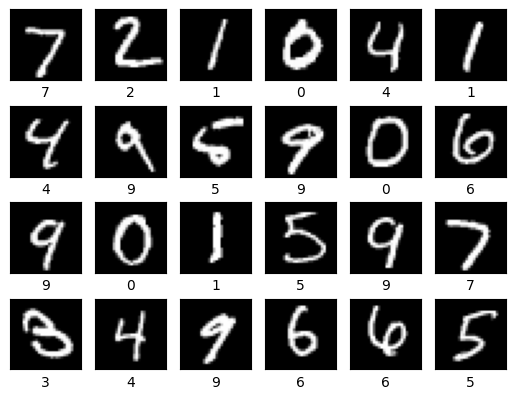

In [ ]:
(_, _), (X, y) = mnist.load_data()
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y[i],
                   color='black')

Чтобы не "умереть" от вычислений, возьемем скромный поднабор из $1000$ элементов. Заодно оценим время работы MDS на таком небольшом наборе данных.

In [ ]:
import time

n_samples = 1000

X_flat = X.reshape(X.shape[0],-1)[:n_samples]
start = time.time()
X_MDS = mds.fit_transform(X_flat)
end = time.time()
print(X_MDS[:3])
print('--------------')
print('Затрачено времени:', end - start)

Визуализируем результат

In [ ]:
plt.figure(figsize=(10,8))
sctr = plt.scatter(x=X_MDS[:,0], y=X_MDS[:,1], c=y[:n_samples])
plt.legend(*sctr.legend_elements())

А если без "раскраски"?

In [ ]:
plt.figure(figsize=(10,8))
sctr = plt.scatter(x=X_MDS[:,0], y=X_MDS[:,1], c='blue')
plt.legend(*sctr.legend_elements())